In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
# Path to dataset
data_dir = "data/archive/train"

img_size = (84, 84)
batch_size = 32
seed = 42

# Training Data
train_data = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale"
)

# Validation Data
val_data = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale"
)

# Split validation into val + test
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches // 2)
val_data = val_data.skip(val_batches // 2)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.


In [3]:
normalization_layer = layers.Rescaling(1./255)

train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
val_data = val_data.map(lambda x, y: (normalization_layer(x), y))
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

In [4]:
model = models.Sequential([

    layers.Input(shape=(84, 84, 1)),

    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 82, 82, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 41, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 39, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)          0

In [5]:
EPOCHS = 15

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)

Epoch 1/15
100/100 [==============================] - 6s 45ms/step - loss: 0.6283 - accuracy: 0.6403 - val_loss: 0.5293 - val_accuracy: 0.7524
Epoch 2/15
100/100 [==============================] - 4s 40ms/step - loss: 0.4942 - accuracy: 0.7225 - val_loss: 0.4415 - val_accuracy: 0.8269
Epoch 3/15
100/100 [==============================] - 4s 38ms/step - loss: 0.4482 - accuracy: 0.7675 - val_loss: 0.4644 - val_accuracy: 0.6923
Epoch 4/15
100/100 [==============================] - 4s 40ms/step - loss: 0.3801 - accuracy: 0.8156 - val_loss: 0.3672 - val_accuracy: 0.7764
Epoch 5/15
100/100 [==============================] - 4s 38ms/step - loss: 0.3469 - accuracy: 0.8419 - val_loss: 0.3247 - val_accuracy: 0.8413
Epoch 6/15
100/100 [==============================] - 4s 42ms/step - loss: 0.3086 - accuracy: 0.8656 - val_loss: 0.2943 - val_accuracy: 0.8846
Epoch 7/15
100/100 [==============================] - 6s 54ms/step - loss: 0.2906 - accuracy: 0.8731 - val_loss: 0.2766 - val_accuracy: 0.8918

In [6]:
model.evaluate(test_data)

12/12 [==============================] - 0s 25ms/step - loss: 0.0815 - accuracy: 0.9792


[0.08154324442148209, 0.9791666865348816]

In [8]:
model.save("model/LW_eye_model.h5", include_optimizer=False)

In [9]:
def representative_data_gen():
    for images, _ in train_data.take(100):
        yield [images]

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open("eye_model_int8.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\yashw\AppData\Local\Temp\tmp46aeda7p\assets


INFO:tensorflow:Assets written to: C:\Users\yashw\AppData\Local\Temp\tmp46aeda7p\assets
d:\Projects\AI_powered_drowziness__detection_system\venv\lib\site-packages\tensorflow\lite\python\convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [12]:
size = os.path.getsize("eye_model_int8.tflite") / (1024 * 1024)
print("Final Model Size (MB):", size)

Final Model Size (MB): 0.0317535400390625


In [13]:
test_loss, test_accuracy = model.evaluate(test_data)

print("Test Accuracy:", test_accuracy * 100, "%")


12/12 [==============================] - 0s 23ms/step - loss: 0.0737 - accuracy: 0.9870
Test Accuracy: 98.69791865348816 %


In [14]:
print("Last Training Accuracy:", history.history['accuracy'][-1] * 100, "%")
print("Last Validation Accuracy:", history.history['val_accuracy'][-1] * 100, "%")


Last Training Accuracy: 96.21875286102295 %
Last Validation Accuracy: 97.3557710647583 %


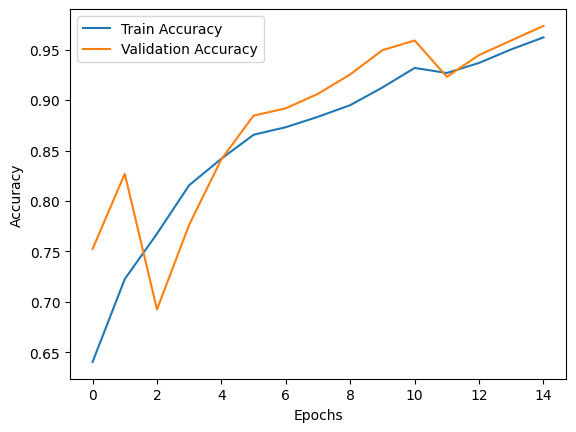

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


1/1 [==============================] - 0s 34ms/step


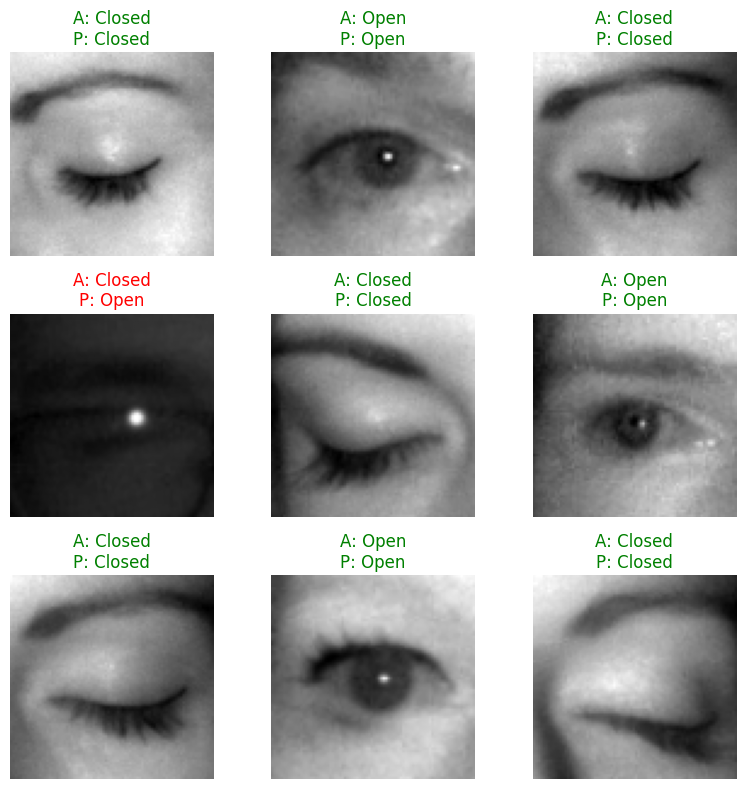

In [22]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ["Closed", "Open"]

# Get one batch from test data
for images, labels in test_data.take(1):
    images = images.numpy()
    labels = labels.numpy()

# Predict
predictions = model.predict(images)
predicted_labels = (predictions > 0.5).astype("int32").flatten()

plt.figure(figsize=(8,8))

num_images = min(9, len(images))

for i in range(num_images):
    plt.subplot(3,3,i+1)
    
    img = np.squeeze(images[i])
    
    plt.imshow(img, cmap='gray')
    
    actual = class_names[int(labels[i])]
    predicted = class_names[int(predicted_labels[i])]
    
    # Color red if wrong, green if correct
    color = "green" if actual == predicted else "red"
    
    plt.title(f"A: {actual}\nP: {predicted}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [25]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# Load model
model = tf.keras.models.load_model("model/LW_eye_model.h5")
class_names = ["Closed", "Open"]

# Initialize MediaPipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

cap = cv2.VideoCapture(0)

def extract_eye(frame, landmarks, eye_indices):
    h, w, _ = frame.shape
    points = [(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in eye_indices]

    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]

    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    eye = frame[y_min:y_max, x_min:x_max]
    return eye

# Left eye landmark indices
LEFT_EYE = [33, 160, 158, 133, 153, 144]

while True:
    ret, frame = cap.read()
    if not ret:
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:

            eye = extract_eye(frame, face_landmarks.landmark, LEFT_EYE)

            if eye.size != 0:
                gray_eye = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
                gray_eye = cv2.resize(gray_eye, (84, 84))
                gray_eye = gray_eye / 255.0
                gray_eye = np.reshape(gray_eye, (1, 84, 84, 1))

                prediction = model.predict(gray_eye, verbose=0)
                label = class_names[int(prediction > 0.5)]

                color = (0,255,0) if label == "Open" else (0,0,255)

                cv2.putText(frame, label, (30,50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    cv2.imshow("MediaPipe Drowsiness Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

d:\Projects\AI_powered_drowziness__detection_system\venv\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
